In [20]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

In [21]:
import json 

recs=[json.loads(line) for line in open('./dataset/pydata-book/datasets/bitly_usagov/example.txt')]

# jsonのtzの頻度を分析(tzのkeyがあるもののみ)
tz=[rec['tz'] for rec in recs if 'tz' in rec]

# tzの頻度分布

In [22]:
from collections import Counter

counts=Counter(tz)

# 頻度が高いtzを出力
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

In [23]:
# DataFrameで頻度を出力
frame=pd.DataFrame(recs)

frame.tz.value_counts().head(10)

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

In [24]:
# 欠損値を埋める
clean_tz=frame['tz'].fillna('Missing')
clean_tz[clean_tz=='']='Unknown'

tz_count=clean_tz.value_counts()

tz_count.head(10)

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

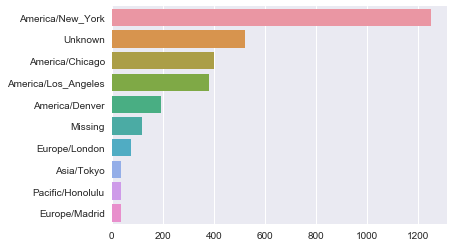

In [25]:
# barplotで頻度を比較
subset=tz_count[:10]

sns.barplot(y=subset.index,x=subset.values)

# OSについて分析

In [26]:
results=pd.Series(x.split()[0] for x in frame.a.dropna())

results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

## Winであることと、tzの相関を考える

In [27]:
# nullでないもののみにしぼる
cframe=frame[frame.notnull()]

# Winかでないかに分ける
cframe['os']=np.where(cframe['a'].str.contains('Windows'),'Win','NoWin')

cframe.os.head()

0      Win
1    NoWin
2      Win
3    NoWin
4      Win
Name: os, dtype: object

In [28]:
by_tz_os=cframe.groupby(['tz','os'])

# 頻度で集計
by_tz_os.size().head()

tz                 os   
                   NoWin    245
                   Win      276
Africa/Cairo       Win        3
Africa/Casablanca  Win        1
Africa/Ceuta       Win        2
dtype: int64

In [29]:
# unstackでWin/NoWinをcolumnに持ってくる
agg_counts=by_tz_os.size().unstack(level=1).fillna(0.0)

agg_counts.head()

os,NoWin,Win
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0


In [30]:
# Win/NoWinの合計が多い順のindex
indexer=agg_counts.sum(1).argsort()

# 10番目まで出力
count_subset=agg_counts.take(indexer[-10:])

count_subset

os,NoWin,Win
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


In [31]:
# またはnlargetstでも同等
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

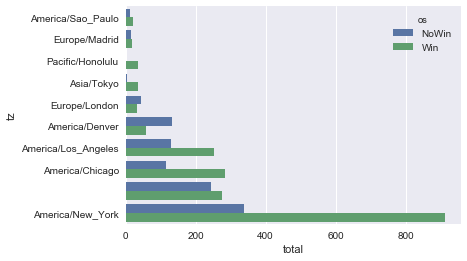

In [32]:
# barで構成を比較
count_subset=count_subset.stack()
count_subset.name='total'

count_subset=count_subset.reset_index()
sns.barplot(x='total',y='tz',hue='os',data=count_subset)

In [33]:
# 規格化
def norm_total(group):
    group['normed_group']=group.total/group.total.sum()
    return group

results=count_subset.groupby('tz').apply(norm_total)

results.head()

,tz,os,total,normed_group
0,America/Sao_Paulo,NoWin,13.0,0.393939
1,America/Sao_Paulo,Win,20.0,0.606061
2,Europe/Madrid,NoWin,16.0,0.457143
3,Europe/Madrid,Win,19.0,0.542857
4,Pacific/Honolulu,NoWin,0.0,0.000000


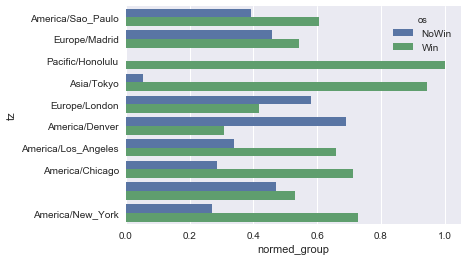

In [34]:
sns.barplot(x='normed_group',y='tz',hue='os',data=results)

In [35]:
# 規格化したければ、transformが使える
results2=count_subset.total/count_subset.groupby('tz').total.transform('sum')

results2.head()

0    0.393939
1    0.606061
2    0.457143
3    0.542857
4    0.000000
Name: total, dtype: float64

In [38]:
# データの表示を絞る
pd.options.display.max_rows=10

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('./dataset/pydata-book/datasets/movielens/users.dat', sep='::',
                      header=None, names=unames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('./dataset/pydata-book/datasets/movielens/ratings.dat', sep='::',
                        header=None, names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('dataset/pydata-book/datasets/movielens/movies.dat', sep='::',
                       header=None, names=mnames)

/Users/hiroaki/.pyenv/versions/pycoon/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/hiroaki/.pyenv/versions/pycoon/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/Users/hiroaki/.pyenv/versions/pycoon/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can a

In [40]:
users

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [41]:
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [43]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [47]:
# データの結合(mergeは名前が一致するcolumn同士を結合してくれる)
data=pd.merge(pd.merge(ratings,users),movies )

data

# レーティングとタイトルの関係

In [58]:
# レーティングをtitleごとに分析
ratings_by_title=data.groupby('title').size().sort_values()

ratings_by_title.iloc[-20:]

title
Groundhog Day (1993)                                     2278
L.A. Confidential (1997)                                 2288
Schindler's List (1993)                                  2304
Princess Bride, The (1987)                               2318
Shakespeare in Love (1998)                               2369
                                                         ... 
Jurassic Park (1993)                                     2672
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode IV - A New Hope (1977)                2991
American Beauty (1999)                                   3428
Length: 20, dtype: int64

In [63]:
# activeなタイトルに絞る
active_title=ratings_by_title.index[ratings_by_title>250]
active_title

Index(['Top Hat (1935)', 'Wes Craven's New Nightmare (1994)',
       'Presidio, The (1988)',
       'Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)',
       'Man Who Knew Too Little, The (1997)', 'Take the Money and Run (1969)',
       'Bicycle Thief, The (Ladri di biciclette) (1948)',
       'Bachelor, The (1999)', 'Bottle Rocket (1996)', '39 Steps, The (1935)',
       ...
       'Silence of the Lambs, The (1991)', 'Back to the Future (1985)',
       'Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)',
       'Saving Private Ryan (1998)', 'Jurassic Park (1993)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)', 'American Beauty (1999)'],
      dtype='object', name='title', length=1214)

In [72]:
# 平均レートを算出
# 男女で比較するためpivotを使う
mean_ratings=data.pivot_table('rating',index='title',columns='gender',aggfunc='mean')

mean_ratings

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024
...,...,...
"Zed & Two Noughts, A (1985)",3.500000,3.380952
Zero Effect (1998),3.864407,3.723140
Zero Kelvin (Kj�rlighetens kj�tere) (1995),NaN,3.500000


In [74]:
# アクティブなtitleでratringの男女差を確認
mean_ratings.loc[active_title]

gender,F,M
title,,
Top Hat (1935),4.245763,4.060150
Wes Craven's New Nightmare (1994),2.761905,2.832536
"Presidio, The (1988)",3.547619,3.253589
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991),2.152174,2.121951
"Man Who Knew Too Little, The (1997)",3.071429,3.178571
...,...,...
Jurassic Park (1993),3.579407,3.814197
Star Wars: Episode VI - Return of the Jedi (1983),3.865237,4.069058
Star Wars: Episode V - The Empire Strikes Back (1980),4.106481,4.344577


In [79]:
# ratingの差分
mean_ratings['diff']=mean_ratings['M']-mean_ratings['F']

# 差分が多い順にsort
sort_by_diff=mean_ratings.sort_values(by='diff')

sort_by_diff

gender,F,M,diff
title,,,
"James Dean Story, The (1957)",4.000000,1.000000,-3.000000
Country Life (1994),5.000000,2.000000,-3.000000
"Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)",4.000000,1.000000,-3.000000
Babyfever (1994),3.666667,1.000000,-2.666667
"Woman of Paris, A (1923)",5.000000,2.428571,-2.571429
...,...,...,...
With Friends Like These... (1998),NaN,4.000000,NaN
"Wooden Man's Bride, The (Wu Kui) (1994)",NaN,3.000000,NaN
Year of the Horse (1997),NaN,3.250000,NaN


In [81]:
sort_by_diff[::-1]

gender,F,M,diff
title,,,
Zero Kelvin (Kj�rlighetens kj�tere) (1995),NaN,3.500000,NaN
Zachariah (1971),NaN,3.500000,NaN
Year of the Horse (1997),NaN,3.250000,NaN
"Wooden Man's Bride, The (Wu Kui) (1994)",NaN,3.000000,NaN
With Friends Like These... (1998),NaN,4.000000,NaN
...,...,...,...
"Woman of Paris, A (1923)",5.000000,2.428571,-2.571429
Babyfever (1994),3.666667,1.000000,-2.666667
"Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)",4.000000,1.000000,-3.000000


In [88]:
# 偏差を計算することで、どの映画が一番物議をかもしたか判定する
ratring_std_by_title=data.groupby('title')['rating'].std().dropna().loc[active_title]

ratring_std_by_title.sort_values(ascending=False)

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
                                           ...   
Wrong Trousers, The (1993)               0.708666
Shawshank Redemption, The (1994)         0.700443
Great Escape, The (1963)                 0.692585
Rear Window (1954)                       0.688946
Close Shave, A (1995)                    0.667143
Name: rating, Length: 1214, dtype: float64

# US Baby Names 1880–2010